In [1]:
# module imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression


data = pd.read_csv('food.csv')

# display first few rows
data.head()


,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,cereals and tubers,Maize,KG,actual,Wholesale,KES,16.13,0.2235
2,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans,KG,actual,Wholesale,KES,33.63,0.4659
3,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans (dry),90 KG,actual,Wholesale,KES,3246,44.9705
4,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,cereals and tubers,Maize (white),KG,actual,Retail,KES,17,0.2355


## Preprossesing the data

In [2]:
# dropping the first row containing repeated headers
cleaned_data = data.drop(index=0).reset_index(drop=True)

# display the first few rows of the cleaned dataset
cleaned_data.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,cereals and tubers,Maize,KG,actual,Wholesale,KES,16.13,0.2235
1,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans,KG,actual,Wholesale,KES,33.63,0.4659
2,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans (dry),90 KG,actual,Wholesale,KES,3246,44.9705
3,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,cereals and tubers,Maize (white),KG,actual,Retail,KES,17,0.2355
4,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,pulses and nuts,Beans (dry),KG,actual,Retail,KES,39,0.5403


In [3]:
# Temporal Features

# ensure the column is named correctly
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# extract year and month
cleaned_data['year'] = cleaned_data['date'].dt.year
cleaned_data['month'] = cleaned_data['date'].dt.month

cleaned_data['day_of_week'] = cleaned_data['date'].dt.dayofweek  # Day of the week
cleaned_data['day_of_year'] = cleaned_data['date'].dt.dayofyear  # Day of the year

# cyclic encoding for month
cleaned_data['month_sin'] = np.sin(2 * np.pi * cleaned_data['month']/12)
cleaned_data['month_cos'] = np.cos(2 * np.pi * cleaned_data['month']/12)

# holiday season indicator (December only)
cleaned_data['is_holiday_season'] = (cleaned_data['month'] == 12).astype(int)

cleaned_data.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,...,currency,price,usdprice,year,month,day_of_week,day_of_year,month_sin,month_cos,is_holiday_season
0,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,cereals and tubers,Maize,KG,actual,...,KES,16.13,0.2235,2006,1,6,15,0.5,0.866025,0
1,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans,KG,actual,...,KES,33.63,0.4659,2006,1,6,15,0.5,0.866025,0
2,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans (dry),90 KG,actual,...,KES,3246,44.9705,2006,1,6,15,0.5,0.866025,0
3,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,cereals and tubers,Maize (white),KG,actual,...,KES,17,0.2355,2006,1,6,15,0.5,0.866025,0
4,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,pulses and nuts,Beans (dry),KG,actual,...,KES,39,0.5403,2006,1,6,15,0.5,0.866025,0


In [4]:
# Location-based features

# Create location clusters based on latitude and longitude
cleaned_data['location_cluster'] = (
    cleaned_data.groupby(['latitude', 'longitude'])
    .ngroup()
    .astype('category')
)

# Create market density features (number of unique markets per region)
market_counts = cleaned_data.groupby('admin1')['admin2'].nunique()
cleaned_data['markets_in_region'] = cleaned_data['admin1'].map(market_counts)

cleaned_data.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,...,usdprice,year,month,day_of_week,day_of_year,month_sin,month_cos,is_holiday_season,location_cluster,markets_in_region
0,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,cereals and tubers,Maize,KG,actual,...,0.2235,2006,1,6,15,0.5,0.866025,0,32,4
1,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans,KG,actual,...,0.4659,2006,1,6,15,0.5,0.866025,0,32,4
2,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans (dry),90 KG,actual,...,44.9705,2006,1,6,15,0.5,0.866025,0,32,4
3,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,cereals and tubers,Maize (white),KG,actual,...,0.2355,2006,1,6,15,0.5,0.866025,0,19,6
4,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,pulses and nuts,Beans (dry),KG,actual,...,0.5403,2006,1,6,15,0.5,0.866025,0,19,6


In [5]:
# Price-related features

# price-to-usd ratio
# Convert 'price' and 'usdprice' columns to numeric, handling errors
cleaned_data['price'] = pd.to_numeric(cleaned_data['price'], errors='coerce')
cleaned_data['usdprice'] = pd.to_numeric(cleaned_data['usdprice'], errors='coerce')

# price-usd ratio
cleaned_data['price_to_usd_ratio'] = cleaned_data['price'] / cleaned_data['usdprice']

# price categories
cleaned_data['price_category'] = pd.qcut(cleaned_data['price'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

# rolling average price
cleaned_data['rolling_avg_price'] = (
    cleaned_data.groupby('commodity')['price']
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

#price volatility
cleaned_data['price_volatility'] = (
    cleaned_data.groupby('commodity')['price']
    .transform('std')
)

cleaned_data.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,...,day_of_year,month_sin,month_cos,is_holiday_season,location_cluster,markets_in_region,price_to_usd_ratio,price_category,rolling_avg_price,price_volatility
0,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,cereals and tubers,Maize,KG,actual,...,15,0.5,0.866025,0,32,4,72.170022,very_low,16.13,16.518059
1,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans,KG,actual,...,15,0.5,0.866025,0,32,4,72.182872,very_low,33.63,14.759302
2,2006-01-15,Coast,Mombasa,Mombasa,-4.05,39.666667,pulses and nuts,Beans (dry),90 KG,actual,...,15,0.5,0.866025,0,32,4,72.180652,high,3246.00,3108.354260
3,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,cereals and tubers,Maize (white),KG,actual,...,15,0.5,0.866025,0,19,6,72.186837,very_low,17.00,1360.323770
4,2006-01-15,Eastern,Kitui,Kitui,-1.366667,38.016667,pulses and nuts,Beans (dry),KG,actual,...,15,0.5,0.866025,0,19,6,72.182121,very_low,1642.50,3108.354260


In [6]:
# Encoding categorical features
le = LabelEncoder()

# Create a copy of the dataset to avoid modifying the original
df_encoded = cleaned_data.copy()

# Step 1: Encode `admin1` (regions)
df_encoded['admin1_encoded'] = le.fit_transform(df_encoded['admin1'])

# Step 2: Encode `admin2` (sub-regions)
df_encoded['admin2_encoded'] = le.fit_transform(df_encoded['admin2'])

# Step 3: Encode `market`
df_encoded['market_encoded'] = le.fit_transform(df_encoded['market'])

# Step 4: Encode `category`
df_encoded['category_encoded'] = le.fit_transform(df_encoded['category'])

# Step 5: Encode `commodity`
df_encoded['commodity_encoded'] = le.fit_transform(df_encoded['commodity'])

# Step 6: Encode `unit`
df_encoded['unit_encoded'] = le.fit_transform(df_encoded['unit'])

# Step 7: Encode `priceflag`
df_encoded['priceflag_encoded'] = le.fit_transform(df_encoded['priceflag'])

# Step 8: Encode `price_category`
df_encoded['price_category_encoded'] = le.fit_transform(df_encoded['price_category'])

# Drop the original categorical columns
columns_to_drop = ['admin1', 'admin2', 'market', 'category', 'commodity', 'unit', 'priceflag', 'price_category']
cleaned_data = df_encoded.drop(columns=columns_to_drop)


cleaned_data.tail()



,date,latitude,longitude,pricetype,currency,price,usdprice,year,month,day_of_week,...,rolling_avg_price,price_volatility,admin1_encoded,admin2_encoded,market_encoded,category_encoded,commodity_encoded,unit_encoded,priceflag_encoded,price_category_encoded
10761,2023-12-15,3.71708,34.850333,Retail,KES,92.0,0.6031,2023,12,4,...,94.610000,22.579004,6,18,48,0,21,11,1,2
10762,2023-12-15,3.71708,34.850333,Retail,KES,73.0,0.4785,2023,12,4,...,73.223333,1087.911293,6,18,48,0,33,11,1,1
10763,2023-12-15,3.71708,34.850333,Retail,KES,800.0,5.2442,2023,12,4,...,733.333333,79.663247,6,18,48,1,24,11,1,0
10764,2023-12-15,3.71708,34.850333,Retail,KES,10.0,0.0656,2023,12,4,...,10.000000,3.301696,6,18,48,3,39,2,1,4
10765,2023-12-15,3.71708,34.850333,Retail,KES,210.5,1.3799,2023,12,4,...,217.500000,36.783762,6,18,48,3,44,11,1,2


In [7]:
# Scaling
# numerical columns to scale
numerical_columns = ['price', 'usdprice', 'price_to_usd_ratio']

scaler = StandardScaler()

cleaned_data[numerical_columns] = scaler.fit_transform(cleaned_data[numerical_columns])

# scaled values
print(cleaned_data[numerical_columns].tail())

          price  usdprice  price_to_usd_ratio
10761 -0.604999 -0.643475            2.667369
10762 -0.611392 -0.648108            2.668199
10763 -0.366755 -0.470925            2.667609
10764 -0.632592 -0.663459            2.661460
10765 -0.565123 -0.614595            2.667486


In [8]:
print(cleaned_data['price_to_usd_ratio'].describe())

count    1.076600e+04
mean     1.098219e-15
std      1.000046e+00
min     -2.454697e+00
25%     -2.892866e-01
50%      1.357015e-01
75%      4.465254e-01
max      2.668917e+00
Name: price_to_usd_ratio, dtype: float64


In [9]:
print(cleaned_data['price_to_usd_ratio'].var())

1.000092893636786


In [10]:
print(cleaned_data[['price', 'usdprice', 'price_to_usd_ratio']].corr())

                       price  usdprice  price_to_usd_ratio
price               1.000000  0.984540            0.125687
usdprice            0.984540  1.000000            0.032973
price_to_usd_ratio  0.125687  0.032973            1.000000


In [11]:
# all imports are at the top of the notebook
# Define the features and target variable
features = [
    'latitude', 'longitude', 'month', 'day_of_week', 'day_of_year',
    'month_sin', 'month_cos', 'is_holiday_season', 'location_cluster',
    'markets_in_region', 'price_to_usd_ratio', 'rolling_avg_price',
    'price_volatility', 'admin1_encoded', 'admin2_encoded',
    'market_encoded', 'category_encoded', 'commodity_encoded',
    'unit_encoded', 'priceflag_encoded', 'price_category_encoded'
]
target = 'price'

# Select the features and target
X = cleaned_data[features]
y = cleaned_data[target]

# Standardize the features
# from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


import pickle
import joblib
 # Save the scaler object for later use
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Models

## 1. Linear Regression

In [12]:
# from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [13]:
# from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)


LinearRegression()

In [14]:
from sklearn.impute import SimpleImputer

# create an imputer object with a strategy (e.g., mean)
imputer = SimpleImputer(strategy='mean')

# fit the imputer to the training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# use the imputed data for prediction
y_train_pred = linear_model.predict(X_train_imputed)
y_test_pred = linear_model.predict(X_test_imputed)


In [15]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate on training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate on test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print("Linear Regression Performance:")
print(f"Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}, Train R2: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.4f}, Test R2: {test_r2:.4f}")

# Save the model
import joblib
joblib.dump(linear_model, 'linear_regression_model.joblib')
print("Linear Regression model saved as 'linear_regression_model.joblib'")


Linear Regression Performance:
Train MSE: 0.0920, Train RMSE: 0.3033, Train R2: 0.9085
Test MSE: 0.0895, Test RMSE: 0.2991, Test R2: 0.9086
Linear Regression model saved as 'linear_regression_model.joblib'


In [16]:
# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred


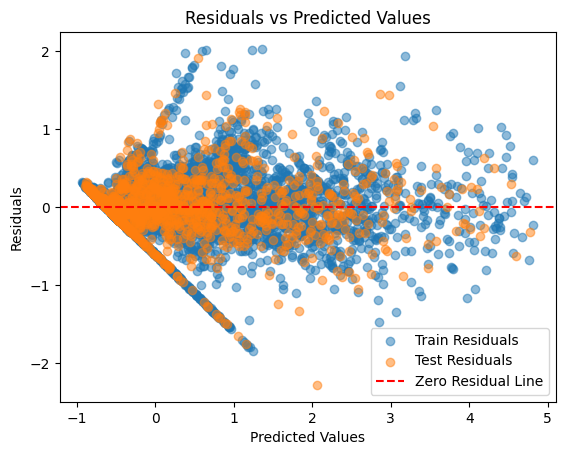

In [17]:
import matplotlib.pyplot as plt

# Plot residuals for training data
plt.scatter(y_train_pred, train_residuals, alpha=0.5, label='Train Residuals')
plt.scatter(y_test_pred, test_residuals, alpha=0.5, label='Test Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## 2. Decision Tree

In [18]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
decision_tree = DecisionTreeRegressor(random_state=42)

# Train the model on the training data
decision_tree.fit(X_train_imputed, y_train)



DecisionTreeRegressor(random_state=42)

In [19]:
# Predict on both training and test data
y_train_pred_tree = decision_tree.predict(X_train_imputed)
y_test_pred_tree = decision_tree.predict(X_test_imputed)

# Evaluate the model
train_mse_tree = mean_squared_error(y_train, y_train_pred_tree)
train_rmse_tree = np.sqrt(train_mse_tree)
train_r2_tree = r2_score(y_train, y_train_pred_tree)

test_mse_tree = mean_squared_error(y_test, y_test_pred_tree)
test_rmse_tree = np.sqrt(test_mse_tree)
test_r2_tree = r2_score(y_test, y_test_pred_tree)

# Print metrics
print("Decision Tree Performance:")
print(f"Train MSE: {train_mse_tree:.4f}, Train RMSE: {train_rmse_tree:.4f}, Train R2: {train_r2_tree:.4f}")
print(f"Test MSE: {test_mse_tree:.4f}, Test RMSE: {test_rmse_tree:.4f}, Test R2: {test_r2_tree:.4f}")

# Save the model
joblib.dump(decision_tree, 'decision_tree_model.joblib')
print("Decision Tree model saved as 'decision_tree_model.joblib'")


Decision Tree Performance:
Train MSE: 0.0000, Train RMSE: 0.0000, Train R2: 1.0000
Test MSE: 0.0442, Test RMSE: 0.2102, Test R2: 0.9549
Decision Tree model saved as 'decision_tree_model.joblib'


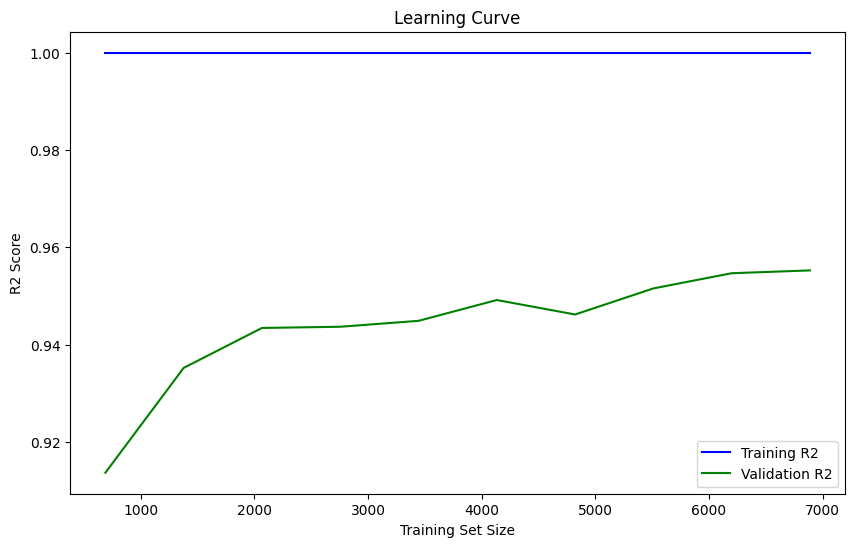

In [ ]:
# plotting learning curve

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    decision_tree, X_train_imputed, y_train, cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training R2', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validation R2', color='green')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('R2 Score')
plt.legend()
plt.show()



## 3. Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
random_forest_model.fit(X_train_imputed, y_train)

# Predict on training and testing data
y_train_pred_rf = random_forest_model.predict(X_train_imputed)
y_test_pred_rf = random_forest_model.predict(X_test_imputed)

# Evaluate the model
train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(train_mse_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)

test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_rmse_rf = np.sqrt(test_mse_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

# Print results
print(f"Random Forest Performance:")
print(f"Train MSE: {train_mse_rf:.4f}, Train RMSE: {train_rmse_rf:.4f}, Train R2: {train_r2_rf:.4f}")
print(f"Test MSE: {test_mse_rf:.4f}, Test RMSE: {test_rmse_rf:.4f}, Test R2: {test_r2_rf:.4f}")

# Save the Random Forest model
joblib.dump(random_forest_model, 'random_forest_model.pkl')


Random Forest Performance:
Train MSE: 0.0034, Train RMSE: 0.0579, Train R2: 0.9967
Test MSE: 0.0240, Test RMSE: 0.1548, Test R2: 0.9755


['random_forest_model.pkl']

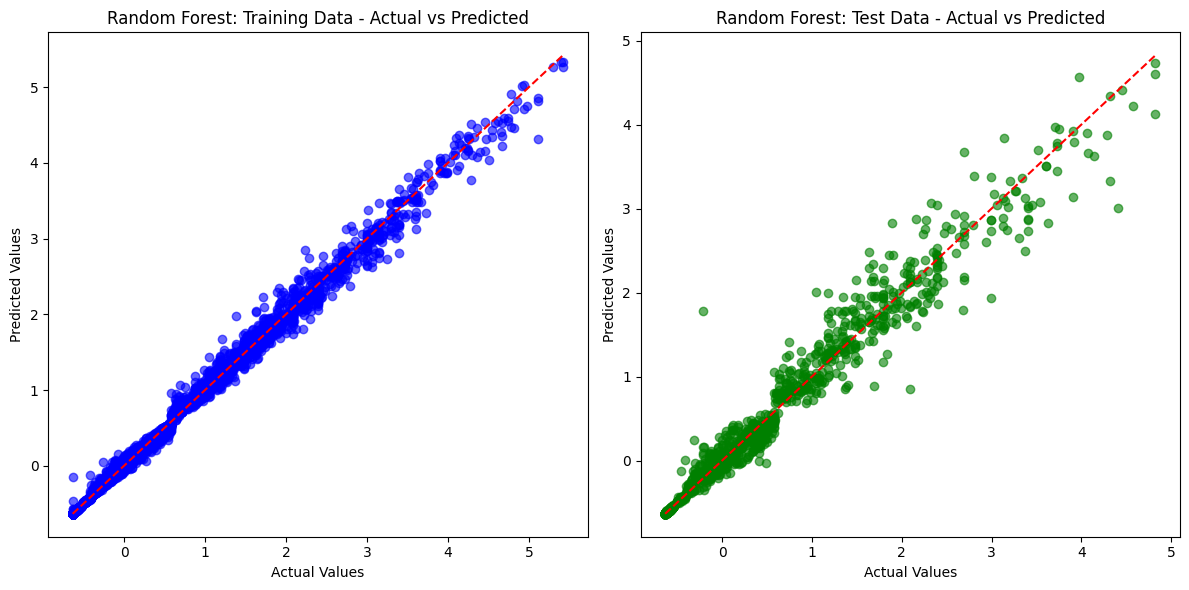

In [24]:
# Scatter Plot for Training and Test Data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rf, alpha=0.6, color='blue')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.title('Random Forest: Training Data - Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, alpha=0.6, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Random Forest: Test Data - Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()


From the training, Random Forest was the most ideal model. But as it turns out, i opted out because in the prediction.py, it predicted negative values. In fact, both Random Forest and Decision Trees predicted negative prices. And while it may be plausible for a country deep in debt to run on deficit, the parameters we are working with would not contribute to negative values.

In [ ]:
df = cleaned_data
print("Training feature count:", X_train.shape[1])
feature_names = df.columns.tolist()
X_train = df.values
print("Training feature names:", feature_names)

Training feature count: 21
Training feature names: ['date', 'latitude', 'longitude', 'pricetype', 'currency', 'price', 'usdprice', 'year', 'month', 'day_of_week', 'day_of_year', 'month_sin', 'month_cos', 'is_holiday_season', 'location_cluster', 'markets_in_region', 'price_to_usd_ratio', 'rolling_avg_price', 'price_volatility', 'admin1_encoded', 'admin2_encoded', 'market_encoded', 'category_encoded', 'commodity_encoded', 'unit_encoded', 'priceflag_encoded', 'price_category_encoded']


In [ ]:
print("Training Data Price Range:")
print(f"Min Price: {cleaned_data['price'].min()}")
print(f"Max Price: {cleaned_data['price'].max()}")


Training Data Price Range:
Min Price: -0.6342745035725837
Max Price: 5.421098940101442
